# MOM adaptation of the LASSO

In [43]:
import sys,os

In [44]:
sys.path.append(os.path.abspath('/Users/charleslaroche/Documents/GitHub/MOM-algorithms/procedure'))

In [45]:
import nbimporter
import numpy as np
import numpy.random as alea
import random as rd
import matplotlib.pyplot as plt
from math import *
import progressbar
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import shuffle
from procedure_MOM import * 
from random_data import *
from sklearn.model_selection import train_test_split
import time
plt.style.use("seaborn-darkgrid")

In [46]:
class MOM_LASSO():
    
    def __init__(self , K, lamb = 1, iter_max = 200): 
        
        self.hist = []
        self.params = {'K' : K , 'iter_max' : iter_max , 'lamb' : lamb}
        
    def set_params(**params):
        
        for key,item in params.item():
            try : 
                self.params[key] = item
                
            except : 
                raise Exception('{} not in params list'.format(key))
    
    def fit(self , X , Y  , method = "ADMM" , step_size = 0.0001 , initialize = "zero"):
        
        n , p = np.shape(X)
        j = n // self.params['K']
        
        if initialize == "zero":
            t = np.zeros(p)
            
        if initialize == "random":
            t = np.random.rand(p)
            
        if initialize == "ones":
            t = np.ones(p)
        
        if method == "ADMM" : 
            if initialize == "zero":
                z = np.zeros(p)
                u = np.zeros(p)
            
            if initialize == "random":
                z = np.random.rand(p)
                u = np.random.rand(p)
                
            if initialize == "ones":
                z = np.ones(p)
                u = np.ones(p)
                
            rhoM = 5 * np.identity(p)
            
            for l in range(self.params['iter_max']) :
                
                k = MOM(P_quadra(X , Y , t) , self.params['K'])[1]
                
                if l >10 :
                    self.hist += k.tolist()
                    
                Xk = X[k]
                Yk = Y[k]
                
                t = np.linalg.solve((Xk.T) @ Xk  +  rhoM, (Xk.T) @ Yk  +  5 * z  -  u)
                z = soft_thresholding(lamb / 5 , t + u / 5)
                u = u + 5 * (t - z)
                
            self.t = t
                
        if method == "ISTA" :
            for l in range(self.params['iter_max']) :
                
                k = MOM(P_quadra( X , Y , t ) , self.params['K'])[1]
                if l>10 :
                    self.hist += k.tolist()
                    
                Xk = X[k]
                Yk = Y[k]
                
                #Beginning of backtracking with c = 1/2
                gamma = 1
                t_prev = t
                F = quadra_loss(Xk , Yk , t_prev)
                
                t = soft_thresholding(lamb * gamma,t - gamma * grad(Xk , Yk , t))
                delta = quadra_loss(Xk , Yk , t) - F - grad(Xk , Yk , t_prev).T * (t - t_prev) - (1 / (2 * gamma)) * np.linalg.norm(t - t_prev) ** 2
                
                while delta > 1e-3 :
                    gamma *= mu
                    t = soft_thresholding(lamb * gamma , t_prev - gamma * grad(Xk , Yk , t_prev))
                    delta = quadra_loss(Xk , Yk , t) - F - grad(Xk , Yk , t_prev).T * (t - t_prev) - (1 / (2 * gamma))*np.linalg.norm(t - t_prev) ** 2
                
            self.t = t
            
        if method == "FISTA" :
            for l in range(self.params['iter_max']) :
                
                k = MOM(P_quadra(X , Y , t) , self.params['K'])[1] 
                if l>10 : 
                    self.hist += k.tolist()
                    
                Xk = X[k]
                Yk = Y[k]
                
                #Beginning of backtracking with c = 1/2
                gamma = 1
                t_prev = t
                F = quadra_loss(Xk , Yk , t_prev)
                
                t = soft_thresholding(lamb * gamma , z - gamma * grad(Xk , Yk , z))
                delta = quadra_loss(Xk , Yk , t) - F - grad(Xk , Yk , t_prev).T * (t - t_prev) - (1 / (2 * gamma)) * np.linalg.norm(t - t_prev) ** 2
                
                while delta > 1e-3 :
                    gamma *= mu
                    t = soft_thresholding(lamb * gamma,z - gamma * grad(Xk , Yk , z))
                    delta = quadra_loss(Xk , Yk , t) - F - grad(Xk , Yk , t_prev).T * (t - t_prev) - (1 / (2 * gamma)) * np.linalg.norm(t - t_prev) ** 2
                    
                z = t + (l / (l + 3)) * (t - t_prev) 
                
            self.t = t
            
        if method == "SUBGRAD" :
             
            for l in range(self.params['iter_max']) :
                k = MOM(P_quadra(X , Y , t) , self.params['K'])[1]
                if l>10 : 
                    self.hist += k.tolist()
                    
                Xk = X[k]
                Yk = Y[k]
                   
                t = t - step_size * subgrad(Xk , Yk , t , lamb) / np.sqrt(l + 1)  
                   
            self.t = t
    
    def predict(self , X):
        return X @ self.t
    
    def score(self , X , Y):
        return quadra_loss(X , Y , self.t)
    
    def get_params(deep = False):
        return self.params
    
    def coefs(self):
        return list(np.array(self.t))

In [49]:
iter_max = 200
n = 2000
n_outliers = 30
features  =  50
sparsity  =  10
lamb  =  1 / np.sqrt(50)
K1  =  5
K2  =  7
step_size1  =  0.01
step_size2  =  0.003
sigma  =  1
t_0  =  create_t_0(features , sparsity)
Y1,X1  =  data1(n , t_0 , 1)
Y2,X2  =  data2(n_outliers , features , type_outliers  =  1)
Y,X  =  data_merge(Y1, X1, Y2, X2)

In [50]:
lamb_list = [0.000000001 * 10**i for i in range(10)]
K_list = [8 * (i+1) for i in range(10)]

res = np.zeros((10,10))

for i,lamb in enumerate(lamb_list):
    for j,K in enumerate(K_list):
        
        model_ = MOM_LASSO(K , lamb = lamb , iter_max = 50)
        score = cross_validation_V_fold(model_, X , Y , 5 , K)
        res[i,j] = np.mean(score)

In [51]:
mini , index = 100000000000 , (0,0)
for i in range(10):
    for j in range(10):
        if res[i,j] < mini:
            mini = res[i,j]
            index = i,j
            print(index)

(0, 0)
(0, 8)
(0, 9)
(1, 9)
(8, 9)


In [52]:
print("Best K =",K_list[index[1]],"Best lambda =",lamb_list[index[0]])

Best K = 80 Best lambda = 0.1


<IPython.core.display.Javascript object>


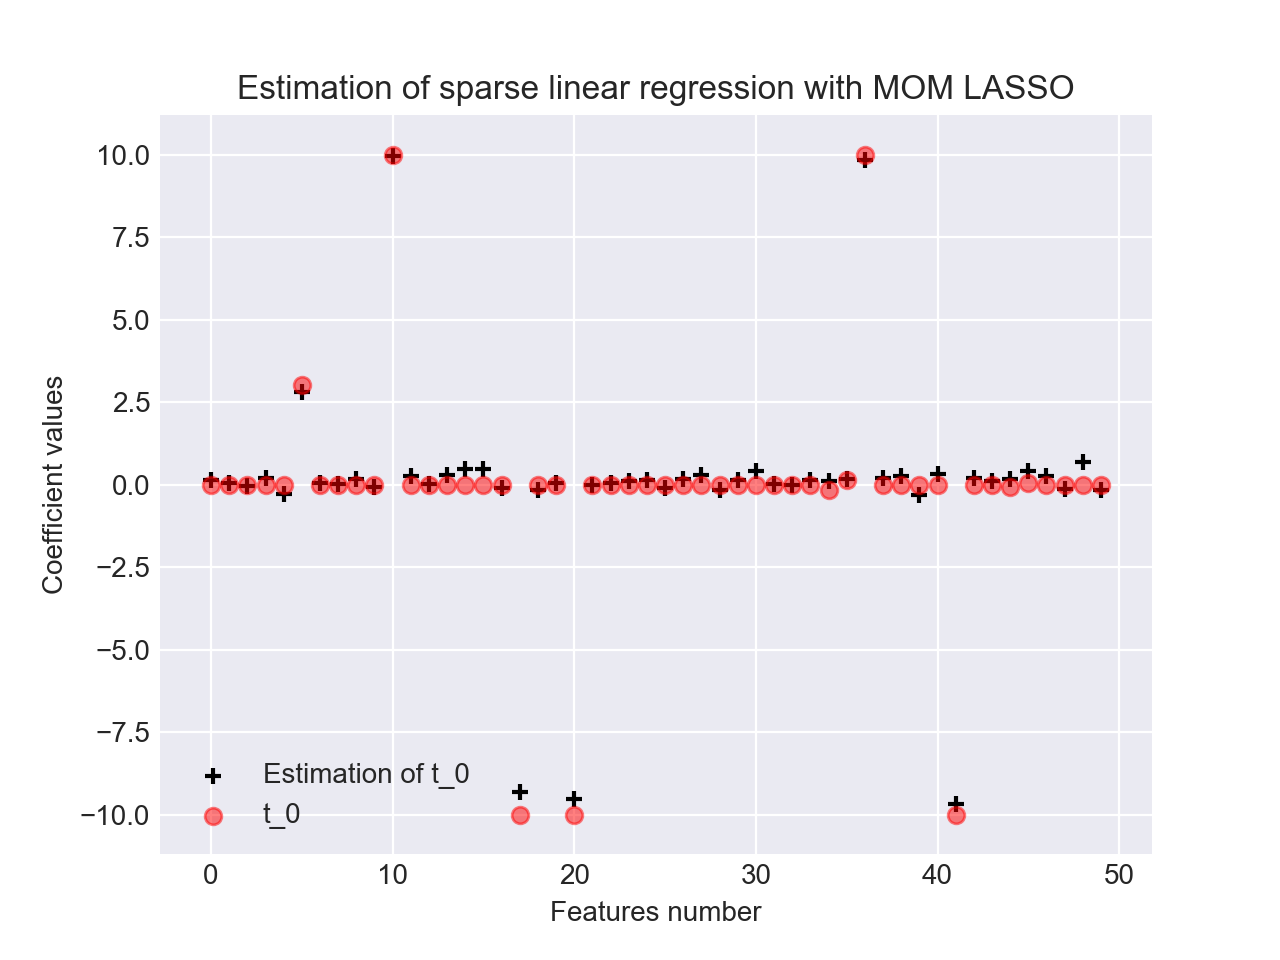

Text(0.5, 0, 'Features number')

In [101]:
%matplotlib notebook
model = MOM_LASSO(50 , lamb = 0.1 , iter_max = 200)
model.fit(X , Y  , step_size = 0.0001 , initialize = "random")
model.coefs()

plt.scatter(np.arange(50) , model.coefs() , label = "Estimation of t_0" , color = 'black' , marker = "+")
plt.scatter(np.arange(50) , t_0 , color = 'red' , alpha = 0.5 , label = "t_0" )
plt.legend()
plt.title("Estimation of sparse linear regression with MOM LASSO")
plt.ylabel("Coefficient values")
plt.xlabel("Features number")

In [87]:
outliers = []

for i in range(2000):
    
    if i not in model.hist :
        outliers.append(i)

In [102]:
c = 0
for i in outliers:
    if Y[i] in [0,1]:
        c+=1

In [103]:
Y[outliers]

array([-10.26091376,  31.61667067,  14.03769268,  19.47650348,
       -20.90331164, -14.17795968,  -7.4152061 , -17.96441247,
       -40.08844299,  11.38965719,   7.26075576, -36.37627918,
        56.86350547,  -0.93409507, -25.29353555,  10.51274044,
        24.45462796, -11.20947244, -20.4071285 ,  29.83312282,
        -4.77329511,  -6.40624075, -20.41403528,  12.97382583,
        -1.27018187,  28.11216976, -21.06712313,   3.17863616,
        16.40299346, -17.21777193,  -1.64496994,  14.11073943,
       -17.83339864,   8.50310731,   1.11152328,  -5.04257457,
       -34.98698282, -13.6320765 ,  18.05678393, -12.89174254,
       -72.22231951, -25.32283807,   5.74151163, -36.25631388,
         6.67390308,  -0.54270076,   0.56527965, -36.64902506,
        -6.23332367])

In [112]:
Y[MOM(np.square(Y - X @ model.t),50)[1]]

array([ 22.72399313,   3.08277325,  18.09972171,  11.36109354,
        21.53821124,  36.43206383,  52.75322665,  36.45173121,
        10.26344499,   2.13901198,  24.53298924, -33.5354214 ,
        15.51032125,   5.60457606,   5.02764635, -44.2385414 ,
         1.03843587,  -3.08286825,  29.29813675,  -4.70555572,
        13.6052054 ,  -7.78574716, -31.83635981,   6.89821044,
        21.88339918, -27.92769475,  26.4340586 ,  26.17302254,
       -14.81473715,  -4.75589223,  45.00291714,  10.40257752,
        18.55206391, -43.8888411 , -25.29155566, -32.19536715,
         1.        , -26.44291625,  37.69841487,  -6.26072482])

### Adaptive choice of K

In [18]:
def cross_validation_V_fold(model , X , Y , V , K , random = False):
    
    n = len(Y)
    
    if random == True : 
        idx = alea.permutation(n)
        
    else : 
        idx = np.arange(n)
    
    score = []
    
    for i in range(V) : 
        
        X_train = np.concatenate((X[idx[ : i * (n // V)]] , X[idx[(i + 1) * (n // V) :]]))  
        Y_train = np.concatenate((Y[idx[ : i * (n // V)]] , Y[idx[(i + 1) * (n // V) :]]))  
        X_test = X[i * (n // V) : (i + 1) * (n // V)]
        Y_test = Y[i * (n // V) : (i + 1) * (n // V)]
        
        model.fit(X_train , Y_train)
        
        err = np.zeros(len(Y_test))
        
        for p in range(len(Y_test)):
            
            err[p] = model.score([X_test[p]],[Y_test[p]])
        
        score.append(MOM(err, K)[0])
        
    return score

In [21]:
def best_K(X , Y):
    
    t1 = time.time()
    _ , p = np.shape(X)
    lamb = 1/ np.sqrt(p)
    score = np.zeros(20)
    
    for K in range(1 , 41 , 2):
        
        model = MOM_LASSO(K)
        score_step = cross_validation_V_fold(model , X , Y , 5 , K , random = True)
        score[K//2] = np.mean(score_step)
        
    t2 = time.time()
    
    print("Time :",(t2-t1) * 10000 // 1 / 10000,"sec")
    return (np.argmin(score) + 1) * 2

In [30]:
iter_max = 200
n = 2000
n_outliers = 3
features  =  50
sparsity  =  10
lamb  =  1
K1  =  5
K2  =  7
step_size1  =  0.01
step_size2  =  0.003
sigma  =  1
t_0  =  create_t_0(features,sparsity)
Y1,X1  =  data1(n,t_0,1)
Y2,X2  =  data2(n_outliers , features , type_outliers  =  2)

Y,X  =  data_merge(Y1, X1, Y2, X2)

best_K(X , Y)

Time : 10.5752 sec


10

### Test of the robustness

In [137]:
import numpy.linalg

In [138]:
from sklearn.linear_model import Lasso

In [141]:
n = 2000
sparsity  =  10
features  =  50
lamb  =  1 / np.sqrt(50)
sigma  =  1
t_0  =  create_t_0(features , sparsity)
Y1 , X1  =  data1(n , t_0 , sigma)
score_MOM = []
score_classic = []
bar = progressbar.progressbar

for n_outliers in bar(range(1 , 200 , 20)) : 
    
    t_0  =  create_t_0(features , sparsity)
    Y2 , X2  =  data2(n_outliers , features , type_outliers  =  1)
    
    if n_outliers == 0 :
        X , Y = X1 , Y1
        
    else : 
        Y , X = data_merge(Y1 , X1 , Y2 , X2)
        
    X_train , X_test , Y_train , Y_test = train_test_split(X , Y)
     
    K = best_K(X_train , Y_train)
    
    
    model_1 = MOM_LASSO(K , lamb = lamb , iter_max = 50)
    model_1.fit(X_train , Y_train , initialize = "ones" )
    Y_mod = model_1.predict(X_test)
    
    outliers = []

    for i in range(2000):
    
        if i not in model_1.hist :
            outliers.append(i)
            
    #print(Y[outliers])
    
    score_MOM.append(MOM(np.square(Y_test-Y_mod) , K)[0])
    
    
    model_2 = Lasso(alpha = lamb)
    model_2.fit(X_train , Y_train)
    Y_mod = model_2.predict(X_test)
    
    score_classic.append(MOM(np.square(Y_test-Y_mod) , K)[0])
    
    
    

100% (10 of 10) |########################| Elapsed Time: 0:01:55 Time:  0:01:55


<IPython.core.display.Javascript object>


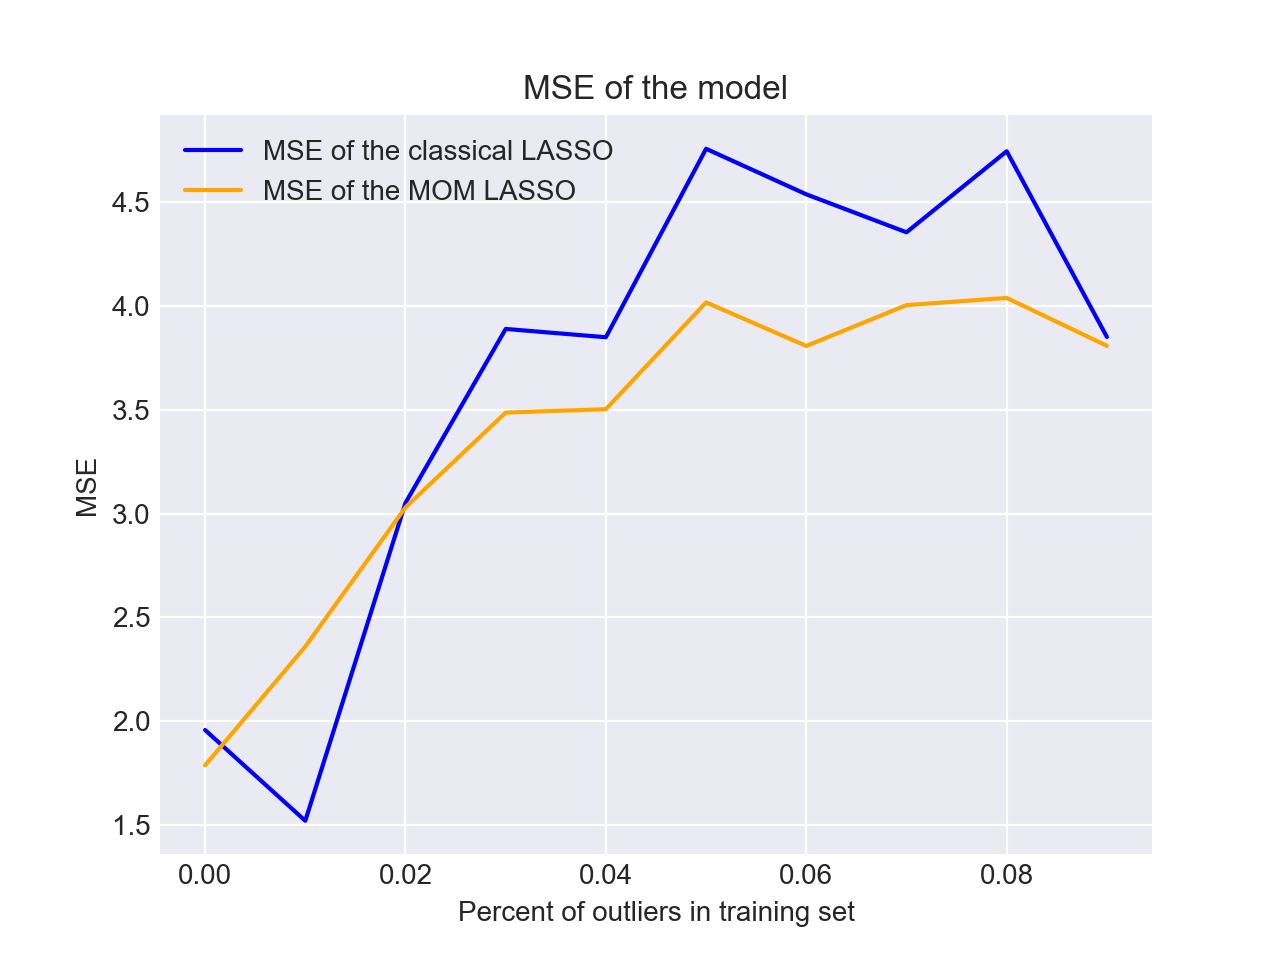

Text(0.5, 1.0, 'MSE of the model')

In [142]:
%matplotlib notebook

l = [(i * 20 )/2000 for i in range(10)]

plt.plot(l , score_classic , color ='blue' , label = "MSE of the classical LASSO")
plt.plot(l , score_MOM , color ='orange' , label = "MSE of the MOM LASSO")
plt.xlabel("Percent of outliers in training set")
plt.ylabel("MSE")
plt.legend()
plt.title("MSE of the model")
#plt.yscale('log')

Source : [1] Regression shrinkage and selection via the lasso, Robert Tibshirani, 1996